#### COSINE ANNEALING LR
##### torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1, verbose=False)
- 코사인 어닐링 스케줄러를 사용하여, 각 매개변수 그룹의 학습 속도를 조정한다.
- $η_{max}$는 초기 lr로 설정되고, $T_{cur}$는 SGDR에서 마지막으로 다시 시작한 이후의 에폭 수 이다.

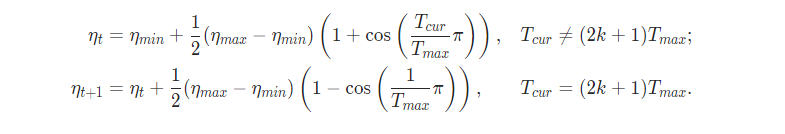

- last_epoch=-1인 경우 초기 lr를 lr로 설정한다. 
- 스케줄러는 재귀적으로 정의되므로, 스케줄러 밖의 다른 연산자에 의해 동시에 수정될 수 있다.
- 이 스케줄러에서만 lr를 설정하면, 각 단계의 lr은 다음과 같다.
- 해당 방법은 [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983)에서 제안되었다. 이는 SGDR의 코사인 어닐링 부분만 구현하고, 재시작은 구현하지 않는다.

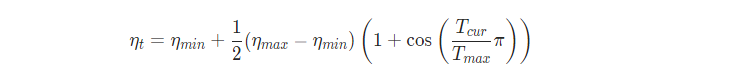

- get_last_lr(): 현재 스케줄러에 의해 계산된 lr를 반환
- load_state_dict(state_dict): 
- print_lr: 현재 lr를 출력

<추가 설명>
- "SGDR: Stochastic Gradient Descent with Warm Restarts"에서 제안되었던 학습율 스케쥴러로서, `학습율의 최대값과 최소값을 정해서 그 범위의 학습율을 코싸인 함수를 이용하여 스케쥴링`하는 방법
- Cosine anneaing의 이점은 `최대값과 최소값 사이에서 코싸인 함수를 이용하여 급격히 증가시켰다가 급격히 감소시키 때문에` 모델의 매니폴드 공간의` 안장(saddle point)를 빠르게 벗어날 수 있으며, 학습 중간에 생기는 정체 구간들 또한 빠르게 벗어날 수 있도록` 한다. 결과적으로 이러한 방법이 모델의 일반화 성능을 극대화시켜준다.

<추가 설명2>
- Cosine Scheduler with warmup  
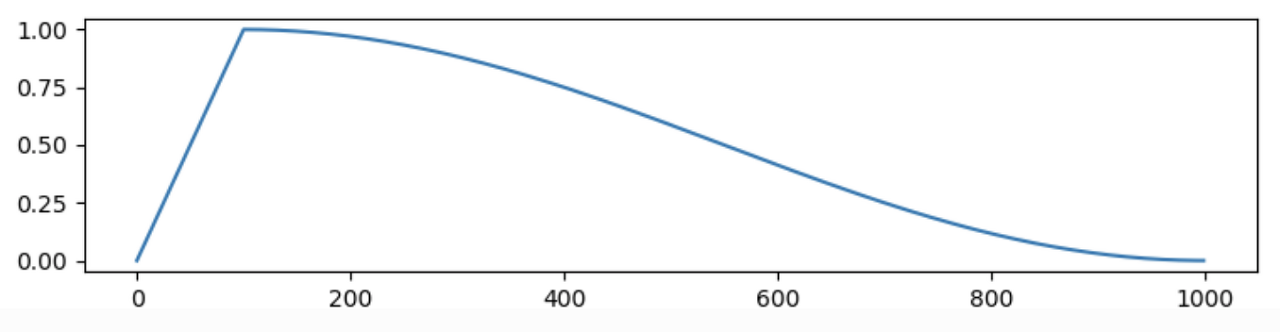
- Cosine with hard restarts scheduler with warmup
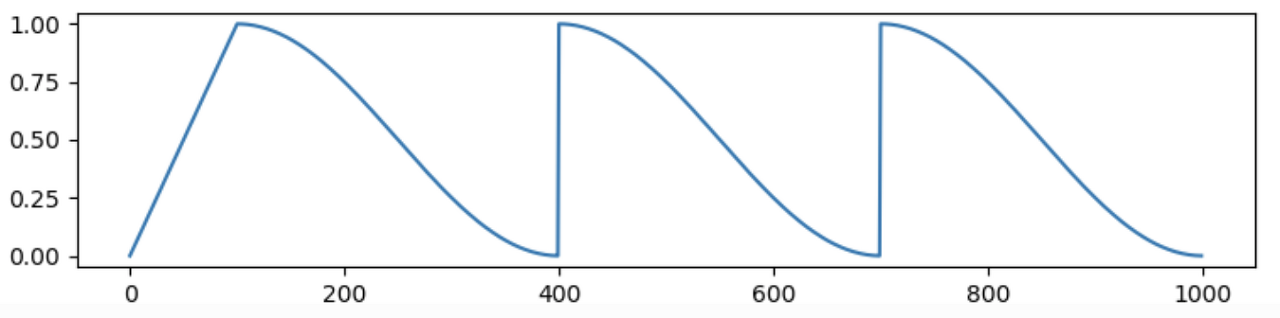

In [ ]:
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult)
iters = len(dataloader)
for epoch in range(20):
    for i, sample in enumerate(dataloader):
        inputs, labels = sample['inputs'], sample['labels']
        optimizer.zero_grad() # <- 파라미터 zero_grad
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step(epoch + i / iters)

In [ ]:
import math
from torch.optim.lr_scheduler import LambdaLR
def get_cosine_schedule_with_warmup(optimizer, num_training_steps, 
                                    num_cycles=7./16., num_warmup_steps=0, last_epoch=-1):
    '''
    Get cosine scheduler (LambdaLR).
    if warmup is needed, set num_warmup_steps (int) > 0.
    '''
    
    def _lr_lambda(current_step):
        '''
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        Decaying criteria: last_epoch
        '''
        if current_step < num_warmup_steps:
            _lr = float(current_step) / float(max(1, num_warmup_steps))
        else:
            num_cos_steps = float(current_step - num_warmup_steps)
            num_cos_steps = num_cos_steps / float(max(1, num_training_steps - num_warmup_steps))
            _lr = max(0.0, math.cos(math.pi * num_cycles * num_cos_steps))
        return _lr
    
    return LambdaLR(optimizer, _lr_lambda, last_epoch)

#### torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1, verbose=False)
- 각 매개변수 그룹의 lr에 지정된 함수에 지정된 인수(factor)를 곱한다.
- last_epoch=-1인 경우 초기 lr을 lr로 설정합니다.

In [ ]:
lmbda = lambda epoch: 0.95
scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()

-----

<목차>
- LambdaLR
- MultiplicativeLR
- StepLR
- MultiStepLR
- CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

In [11]:
import torch
import matplotlib.pyplot as plt
import torchvision.models as models

model = models.__dict__['efficientnet_v2_l']()
optimizer = torch.optim.SGD(model.parameters(), lr=100)

#### LambdaLR
- Lambda 표현식으로 작성한 함수를 통해 learning rate를 조절한다.
- 초기 learning rate에 lambda함수에서 나온 값을 곱해줘서 learning rate를 계산
- lr = 초기 lr * lambda(epoch)

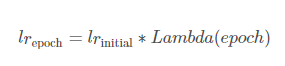

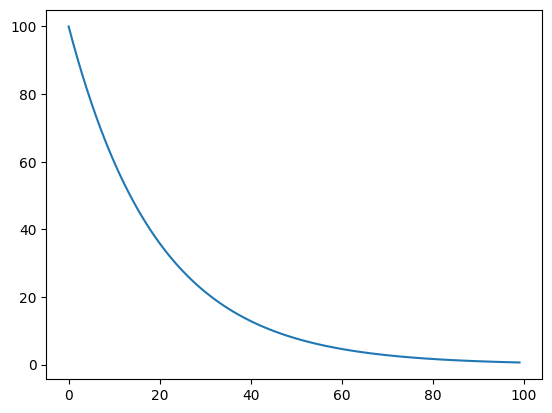

In [12]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch) # 0.95 ^ (epoch) 값을 lr에 곱해서 그 다음 lr로 정한다.

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"]) # optimizer.param_groups[0]["lr"]
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()

#### MultiplicativeLR
- Lambda 표현식으로 작성한 함수를 통해 learning rate를 조절한다. `초기 learning rate에 lambda함수에서 나온 값을 누적곱`해서 learning rate를 계산

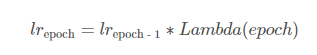

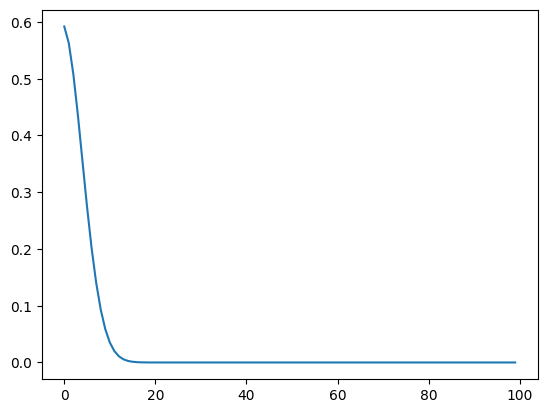

In [13]:
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()


#### Step LR
- 특정 Step에 따라 lr를 감소시키는 Scheduler
- StepLR(optimizer, step_size=20, gamma=0.5)

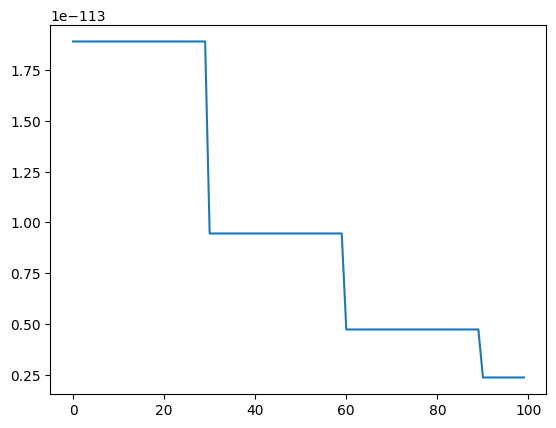

In [14]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()

#### MultiStepLR
- tep size가 아니라 learning rate를 감소시킬 epoch을 지정해줌

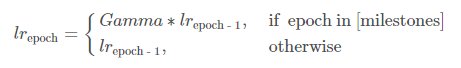

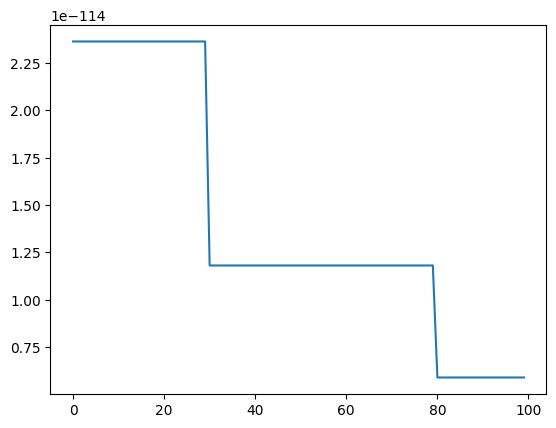

In [16]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()

#### CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
- learing rate가 cos함수를 따라서 eat_min까지 떨어졌다 다시 초기 learning rate까지 올라온다.
- optimizer: 이전에 정의한 optimizer 변수명
- T_max: 최대 iteration 횟수
- eta_min: 최소로 떨어질 수 있는 learning rate (default = 0) 

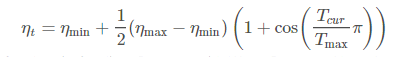

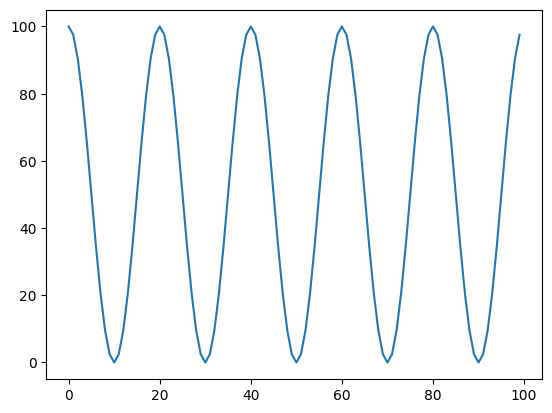

In [18]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()

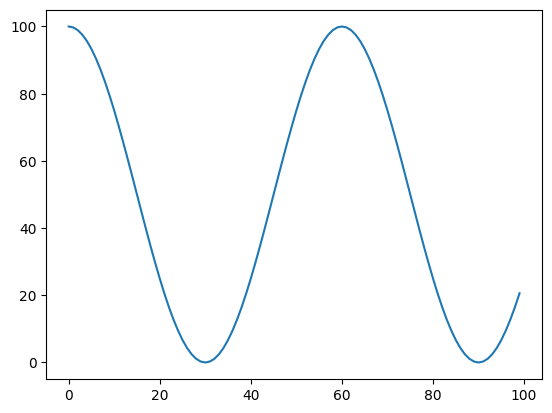

In [19]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(100),lrs)
plt.show()

그 외
- https://panggu15.github.io/etc/pytorch-learning-rate-Scheduler/